# Proyecto 1 - NLP

## Revision de ___ en comentarios de libros 

#### Importación de librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re

from wordcloud import WordCloud, STOPWORDS

#Librerias para sampling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

#Librerias para vectorizacion
from sklearn.feature_extraction.text import TfidfVectorizer

#### Importación de datos

In [2]:
data = pd. read_csv('data/reviews.csv')

#### Preparación e los datos

1. Se se paro la columna helpfull en dpos columnas. Las veces que se le dio helpfull postivo, y las veces totales que se le ha dado helpful

In [3]:
data['Helpful Total'] = data['helpful'].str.replace("[","")
data['Helpful Total'] = data['Helpful Total'].str.replace("]","")
separacion = data['Helpful Total'].str.split(",",expand=True)
data['Helpful Total']=separacion[1].astype(int)
data['Helpful Positivo']=separacion[0].astype(int)
data

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,Helpful Total,Helpful Positivo
0,0,B000F83SZQ,"[0, 0]",5,I enjoy vintage books and movies so I enjoyed ...,"05 5, 2014",A1F6404F1VG29J,Avidreader,Nice vintage story,1399248000,0,0
1,1,B000F83SZQ,"[2, 2]",4,This book is a reissue of an old one; the auth...,"01 6, 2014",AN0N05A9LIJEQ,critters,Different...,1388966400,2,2
2,2,B000F83SZQ,"[2, 2]",4,This was a fairly interesting read. It had ol...,"04 4, 2014",A795DMNCJILA6,dot,Oldie,1396569600,2,2
3,3,B000F83SZQ,"[1, 1]",5,I'd never read any of the Amy Brewster mysteri...,"02 19, 2014",A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",I really liked it.,1392768000,1,1
4,4,B000F83SZQ,"[0, 1]",4,"If you like period pieces - clothing, lingo, y...","03 19, 2014",A3SPTOKDG7WBLN,Father Dowling Fan,Period Mystery,1395187200,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
982614,982614,B00M13FNSS,"[2, 2]",5,Yasss hunny! This is a great read. That Dre is...,"07 23, 2014",A2Y66HD4J5S7QZ,Candi,A Hot Read Indeed!!,1406073600,2,2
982615,982615,B00M13FNSS,"[0, 0]",5,I ENJOYED THIS BOOK FROM BEGINNING TO END NOW ...,"07 23, 2014",A17YHECC8H9NEY,Margie,VERY GOOD BOOK,1406073600,0,0
982616,982616,B00M13FNSS,"[1, 1]",5,Great book! Cherika was a fool. She let that m...,"07 23, 2014",A20KO0BPMNREJL,Nicki,Great Read,1406073600,1,1
982617,982617,B00M13FNSS,"[0, 0]",5,When I say this was an excellent book please b...,"07 23, 2014",A1BQO66R6OLCCW,Nikey,Wow!!,1406073600,0,0


2. Se omiteron los regitso que no han sido calificados helpfull ninguna vezy se calculo la tasa de positividad

In [4]:
# Filtar los reviws que no han sido clasificados como helpful
data = data[data["Helpful Total"] >0 ]
data['Helpful Rate'] = data['Helpful Positivo']/data['Helpful Total']
data.head()

<ipython-input-4-44ad27246076>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Helpful Rate'] = data['Helpful Positivo']/data['Helpful Total']


,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,Helpful Total,Helpful Positivo,Helpful Rate
1,1,B000F83SZQ,"[2, 2]",4,This book is a reissue of an old one; the auth...,"01 6, 2014",AN0N05A9LIJEQ,critters,Different...,1388966400,2,2,1.0
2,2,B000F83SZQ,"[2, 2]",4,This was a fairly interesting read. It had ol...,"04 4, 2014",A795DMNCJILA6,dot,Oldie,1396569600,2,2,1.0
3,3,B000F83SZQ,"[1, 1]",5,I'd never read any of the Amy Brewster mysteri...,"02 19, 2014",A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",I really liked it.,1392768000,1,1,1.0
4,4,B000F83SZQ,"[0, 1]",4,"If you like period pieces - clothing, lingo, y...","03 19, 2014",A3SPTOKDG7WBLN,Father Dowling Fan,Period Mystery,1395187200,1,0,0.0
7,7,B000F83SZQ,"[1, 1]",4,Never heard of Amy Brewster. But I don't need ...,"03 22, 2014",A3DE6XGZ2EPADS,WPY,Enjoyable reading and reminding the old times,1395446400,1,1,1.0


#### Análisis de los datos

 Distribución de la tasa de postividad en helpfull

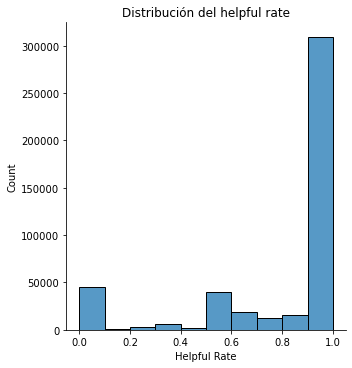

In [5]:
sns.displot(data["Helpful Rate"],bins = 10).set(title="Distribución del helpful rate");

#### Definición  de la vriable de salida

<ipython-input-10-7430b915376c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Output"] = np.where(data["Helpful Rate"] >= 0.9,1, 0)


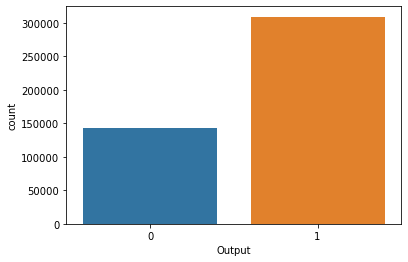

In [10]:
data["Output"] = np.where(data["Helpful Rate"] >= 0.9,1, 0)
sns.countplot(x="Output", data=data);

#### Dataframe NLP 

In [ ]:
df = data[["Output", "reviewText"]]
df = df.reset_index()
df = df.drop(columns=["index"])
df.head()

#### Procesamiento de datos

In [ ]:
import string
import emoji
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import en_core_web_sm
import unidecode
import unicodedata

In [ ]:
# Puntucacion
punctuations = string.punctuation
# Carga los modelos de spacy y las stopwords
parser = en_core_web_sm.load()
stop_words = STOP_WORDS

In [ ]:
def clean_text(text):
    # Elimina espacios, emojis, números y convierte todo a minúscula.
    text = str(text)
    text = text.replace('\n','').replace('\r','').replace('\t','').strip().lower()
    text = re.sub(r'\d+', '', text)
    allchars = [str for str in text] 
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    text=''.join((c for c in unicodedata.normalize('NFD',text) if unicodedata.category(c) != 'Mn'))
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    # Tokenize
    token = parser(text)
    # Lemmatize
    token = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in token]
    # Quita stopwords y signos de puntuación
    token = ' '.join([word for word in token if word not in stop_words and word not in punctuations])
    token = unidecode.unidecode(token)
    token = ' '.join([w for w in token.split() if len(w)>1])
    return token

In [ ]:
df["CleanText"]=df["reviewText"].apply(clean_text)
df.head(10)

In [ ]:
df =df.drop(columns="reviewText")
df.to_csv("dataNLP.csv")

#### Exploración

In [ ]:
plt.figure(figsize=(14,7))
positive_text = ''.join(df[df['Output'] == 1].CleanText)
word_cloud = WordCloud(stopwords = STOPWORDS, max_words = 100, width=1366, height=768, background_color="white").generate(positive_text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud de comentarios postivos',fontsize=20)
plt.show()

In [ ]:
plt.figure(figsize=(14,7))
negative_text = ''.join(str(df[df['Output'] == 0].CleanText))
word_cloud = WordCloud(stopwords = STOPWORDS, max_words = 100, width=1366, height=768, background_color="white").generate(negative_text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud de comentarios negativos',fontsize=20)
plt.show()

#### Conversión a vectores

Importación del nuevo dataset. Solo se toman  50000 registros porque si no es muy pesado para crear lasm atrices y ajustar el modelo.  

In [3]:
df =pd.read_csv('dataNLP.csv', index_col=0)
df=df.dropna()
df=df.iloc[0:50000]

Se separa la muestra 90% train y 10% test

In [7]:
Y = df["Output"]
X = df["CleanText"]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 42)

Se codifican las matrices bajo el algoritmo TF_IDF. Solo se incluyen las ppalabras que están más de 50 veces en el dataframe para evitar palabras no significativas. 

In [8]:
tfidf_vectorizer = TfidfVectorizer(min_df = 50)

x_train_vect = tfidf_vectorizer.fit_transform(x_train).toarray()
x_test_vect = tfidf_vectorizer.transform(x_test).toarray()

In [9]:
x_train_vect.shape

(45000, 4280)

#### Modelo Random Forest con represntación TF - IDF 

Se crea un Pipeline con un modelo RanfomForest que se calibra por medio de  RandomSearchCV para encontrar los hiperparámetros que minimizan el error.

In [10]:
Pipeline_RF = Pipeline(steps = [("RF", RandomForestClassifier())])

Param_RF = {
    'RF__max_depth': np.linspace(1, 20, 20, endpoint=True),
    'RF__max_features': ['auto','log2','sqrt',None],
    'RF__min_samples_split':np.linspace(0.1, 1.0, 10, endpoint=True),
    'RF__min_samples_leaf':np.linspace(0.1, 0.5, 5, endpoint=True)  
}

Grid_RF = RandomizedSearchCV(estimator = Pipeline_RF, param_distributions = Param_RF, scoring = 'accuracy', cv = 5, n_iter = 100, n_jobs = -1)

In [11]:
Grid_RF.fit(x_train_vect,y_train)
print('Mejores Parametros: %s' % Grid_RF.best_params_)
print('Mejor AUC en Train: %.3f' % Grid_RF.best_score_)

Mejores Parametros: {'RF__min_samples_split': 0.2, 'RF__min_samples_leaf': 0.5, 'RF__max_features': None, 'RF__max_depth': 16.0}
Mejor AUC en Train: 0.592


##### Resulatados del modelo 

In [13]:
y_pred = Grid_RF.best_estimator_.predict(x_test_vect)
y_pred_proba = Grid_RF.best_estimator_.predict_proba(x_test_vect)[:,1]
print('La precisión del modelo Random Forest con TF- IDF  calibrado es:', '{:.2f}'.format(accuracy_score(y_test, y_pred)))
print('El AUC del modelo Random Forest con TF- IDF calibrado es:', '{:.2f}'.format(roc_auc_score(y_test, y_pred_proba)))

La precisión del modelo Random Forest con TF- IDF  calibrado es: 0.59
El AUC del modelo Random Forest con TF- IDF calibrado es: 0.50


####  Modelo 2

####  Modelo 3